In [1]:
# QUESTION 2 - 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data1 = pd.read_csv('pp1_md_201607_201607.csv')
data2 = pd.read_csv('pp1_md_201608_201608.csv')
concatdata = pd.concat([data1,data2], axis=0)
concatdata.head(5)

,Unnamed: 0,Date,Time,Size,VWAP,Sign,midQ,BP1,SP1
0,0,20160701,90100020,48.0,5267.916667,-1.0,5268.0,5266.0,5270.0
1,1,20160701,90100270,42.0,5266.571429,-1.0,5268.0,5266.0,5270.0
2,2,20160701,90100518,72.0,5268.444444,1.0,5267.0,5266.0,5268.0
3,3,20160701,90100762,326.0,5270.000000,1.0,5268.0,5266.0,5270.0
4,4,20160701,90101019,6.0,5268.666667,-1.0,5270.0,5268.0,5272.0


In [2]:
def resetindex(dfname):
    dfname.reset_index(drop = True, inplace = True)

resetindex(concatdata)

In [3]:
concatdata.isna().any()

Unnamed: 0    False
Date          False
Time          False
Size           True
VWAP           True
Sign           True
midQ          False
BP1           False
SP1           False
dtype: bool

In [4]:
concatdata.dropna(inplace=True)
concatdata.isna().any()

Unnamed: 0    False
Date          False
Time          False
Size          False
VWAP          False
Sign          False
midQ          False
BP1           False
SP1           False
dtype: bool

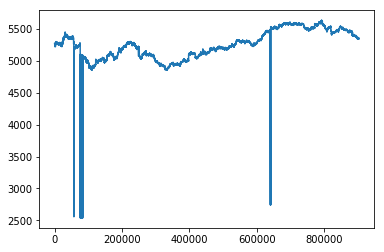

In [5]:
concatdata['midQ'].plot()

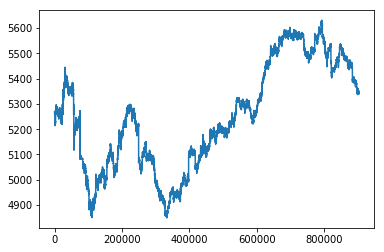

In [6]:
concatdata = concatdata[concatdata['BP1']!=0]
concatdata = concatdata[concatdata['SP1']!=0]
concatdata['midQ'].plot()

In [7]:
resetindex(concatdata)
concatdata.rename(columns= {'Unnamed: 0': 'Trades_each_day'}, inplace = True)
concatdata['Spread'] = concatdata['SP1'] - concatdata['BP1']

In [8]:
# QUESTION 2
delta_t = 250

midq = concatdata['midQ']
p_delay = concatdata['VWAP']
sign = concatdata['Sign']
spread = concatdata['Spread']
R = []

for l in range(0, 500+1):
    if l == 0:
        R.append(np.mean((p_delay-midq)*sign/spread))
        continue
    midq_temp = midq[:-l]
    resetindex(midq_temp)
    sign_temp = sign[:-l]
    resetindex(sign_temp)
    spread_temp = spread[:-l]
    resetindex(spread)
    p_delay_temp = p_delay[l:]
    resetindex(p_delay_temp)
    R.append(np.mean((p_delay_temp - midq_temp) * sign_temp/spread_temp))

R = pd.DataFrame(R, columns=['R'])
R.head(5)

,R
0,0.460389
1,0.183449
2,0.188336
3,0.194868
4,0.199509


[Text(0, 0.5, 'Response Function'),
 Text(0.5, 0, 'Lags'),
 Text(0.5, 1.0, 'Response Function in the unit of Bid-Ask Spread of Prevailing Quote')]

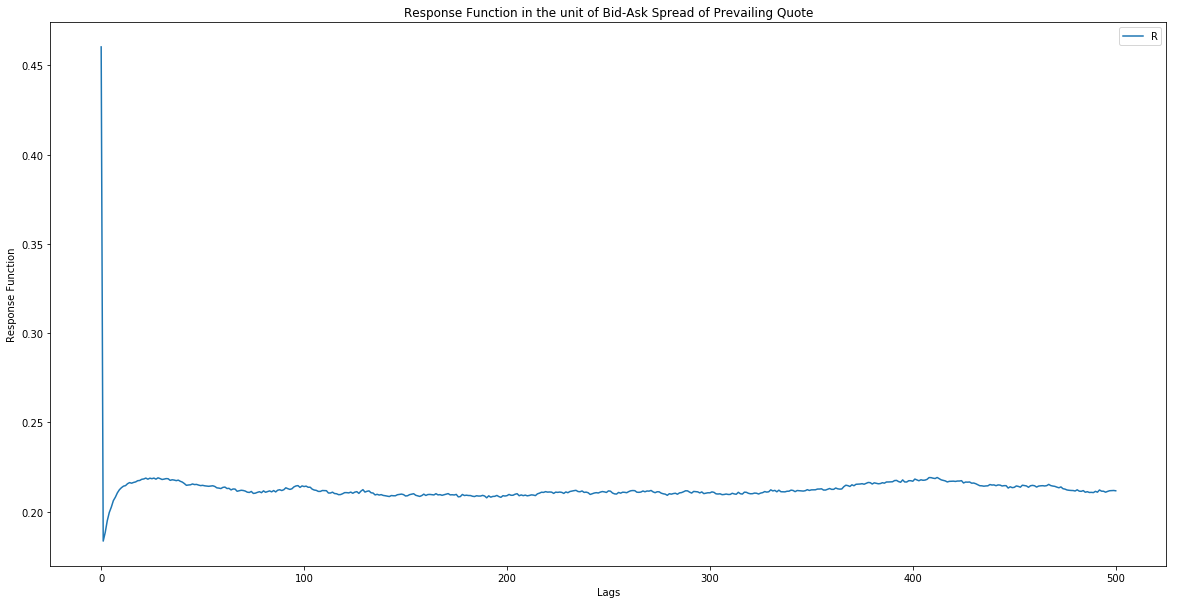

In [21]:
q2 = R.plot(figsize=(20,10))
q2.set(xlabel = 'Lags', ylabel = 'Response Function', title = 'Response Function in the unit of Bid-Ask Spread of Prevailing Quote')

In [10]:
def grouping(lb, ub, data = concatdata):
    groupdata = data[data['Size']>lb]
    groupdata = groupdata[groupdata['Size']<=ub]
    groupdata.reset_index(drop = True, inplace = True)
    return groupdata

def Rcalculate(dfname):
    midq = dfname['midQ']
    p_delay = dfname['VWAP']
    sign = dfname['Sign']
    spread = dfname['Spread']
    R = []

    for l in range(0, 500+1):
        if l == 0:
            R.append(np.mean((p_delay-midq)*sign/spread))
            continue
        midq_temp = midq[:-l]
        resetindex(midq_temp)
        sign_temp = sign[:-l]
        resetindex(sign_temp)
        spread_temp = spread[:-l]
        resetindex(spread)
        p_delay_temp = p_delay[l:]
        resetindex(p_delay_temp)
        R.append(np.mean((p_delay_temp - midq_temp) * sign_temp/spread_temp))

    R = pd.Series(R)
    return R

In [11]:
# QUESTION 3

group0_2 = grouping(0,2)
group2_5 = grouping(2,5)
group5_10 = grouping(5,10)
group10_15 = grouping(10,15)
group15_20 = grouping(15,20)
group20_30 = grouping(20,30)
group30_40 = grouping(30,40)
group40_55 = grouping(40,55)
group55_90 = grouping(55,90)
group90_100000 = grouping(90,100000)

group_R = pd.DataFrame()
for i in [group0_2, group2_5, group5_10, group10_15, group15_20, 
          group20_30, group30_40, group40_55, group55_90, group90_100000]:
    temp_R = Rcalculate(i)
    group_R = pd.concat([group_R, temp_R], axis = 1)


[Text(0, 0.5, 'Responese'),
 Text(0.5, 0, 'Lag'),
 Text(0.5, 1.0, 'The Resposne Function of Different Groups ')]

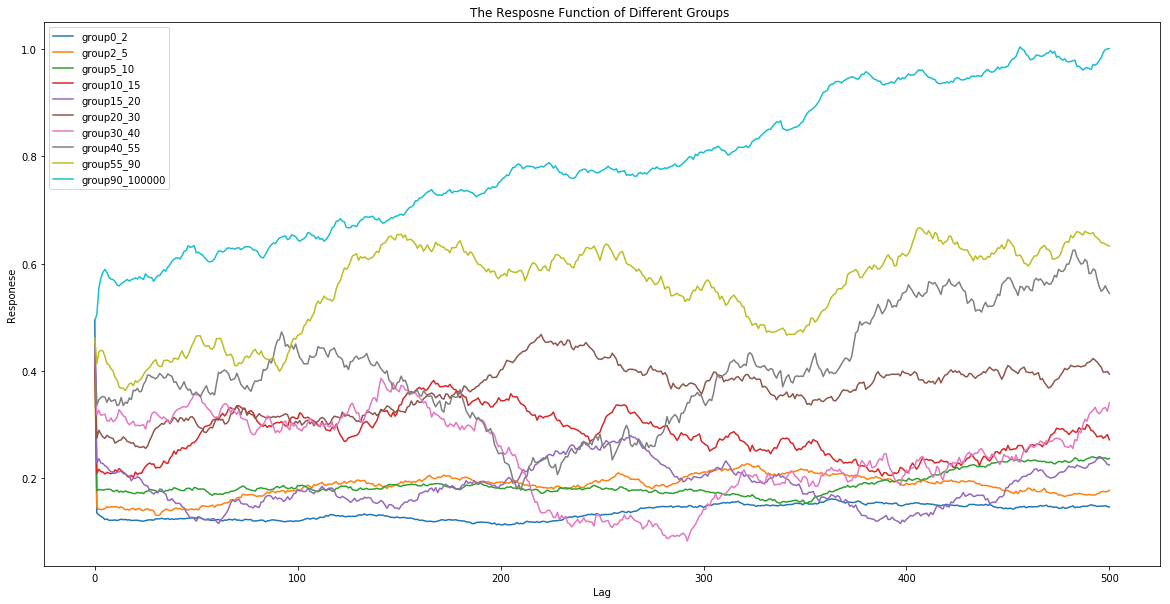

In [19]:
group_R.columns = ['group0_2', 'group2_5', 'group5_10', 'group10_15', 'group15_20', 
          'group20_30', 'group30_40', 'group40_55', 'group55_90', 'group90_100000']
q3 = group_R.plot(figsize = (20,10))
q3.set(title = 'The Resposne Function of Different Groups ',xlabel = 'Lag', ylabel = 'Responese')

Comment: As shown in above, 
(1) Response function give larger values when the size of the trades are larger. 
(2) For the trades with a small size (size < 10), the volatilties of the response values are also smaller than the the large size ones.
(3) With increasing lags, the response value of large size trades get larger.

In [13]:
# QUESTION 4

def LogRcalculate(l):
    from math import log
    logR = []

    for group in [group0_2, group2_5, group5_10, group10_15, group15_20, 
          group20_30, group30_40, group40_55, group55_90, group90_100000]:
        
        midq_temp = group['midQ'][:-l]
        resetindex(midq_temp)
        sign_temp = group['Sign'][:-l]
        resetindex(sign_temp)
        spread_temp = group['Spread'][:-l]
        resetindex(spread)
        p_delay_temp = group['VWAP'][l:]
        resetindex(p_delay_temp)
        logR.append(log(np.mean((p_delay_temp - midq_temp) * sign_temp/spread_temp)))

    logR = pd.DataFrame(logR)
    return logR

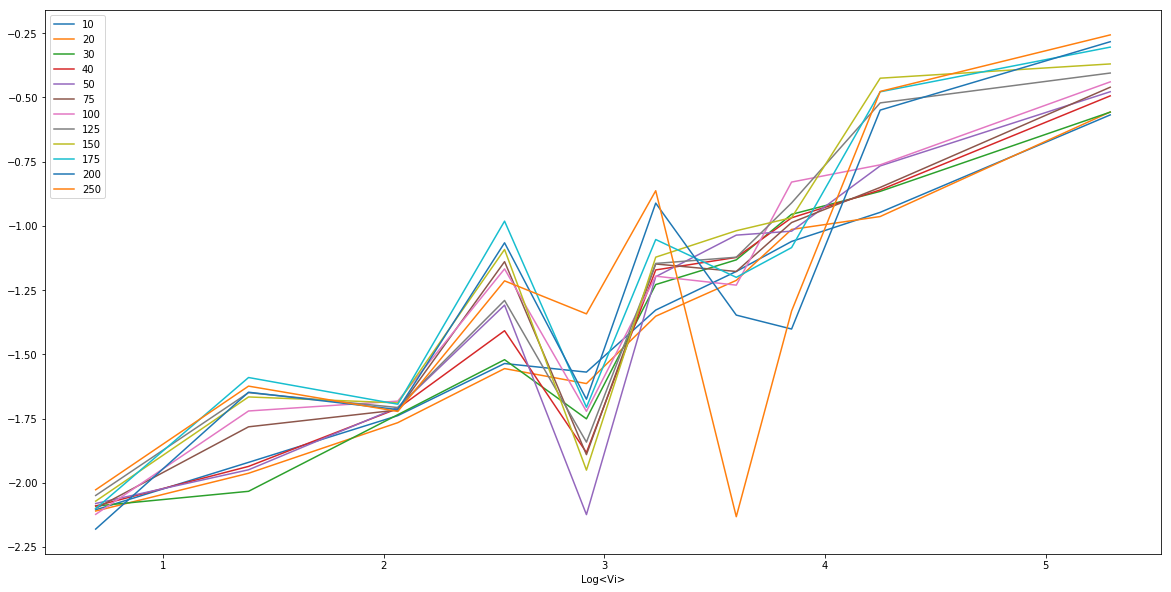

In [23]:
from math import log
import statsmodels.api as sm

LogR = pd.DataFrame()

logV = []
for group in [group0_2, group2_5, group5_10, group10_15, group15_20, 
          group20_30, group30_40, group40_55, group55_90, group90_100000]:
    logV.append(log(group['Size'].mean()))

for i in [10,20,30,40,50,75,100,125,150,175,200,250]:
    Log_temp = LogRcalculate(i)
    LogR = pd.concat([LogR, Log_temp], axis=1)

LogR = pd.concat([LogR,pd.DataFrame(logV, columns=['Log<Vi>'])], axis = 1)
LogR.set_index('Log<Vi>',inplace = True)
LogR.columns = [10,20,30,40,50,75,100,125,150,175,200,250]
LogR.plot(figsize=(20,10))

[Text(0, 0.5, 'LogR'),
 Text(0.5, 1.0, 'Log Response Function of Lags with Different Group Size')]

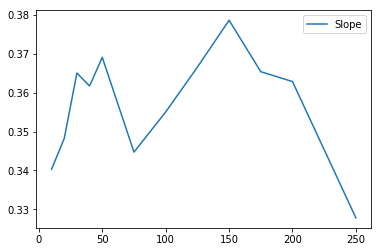

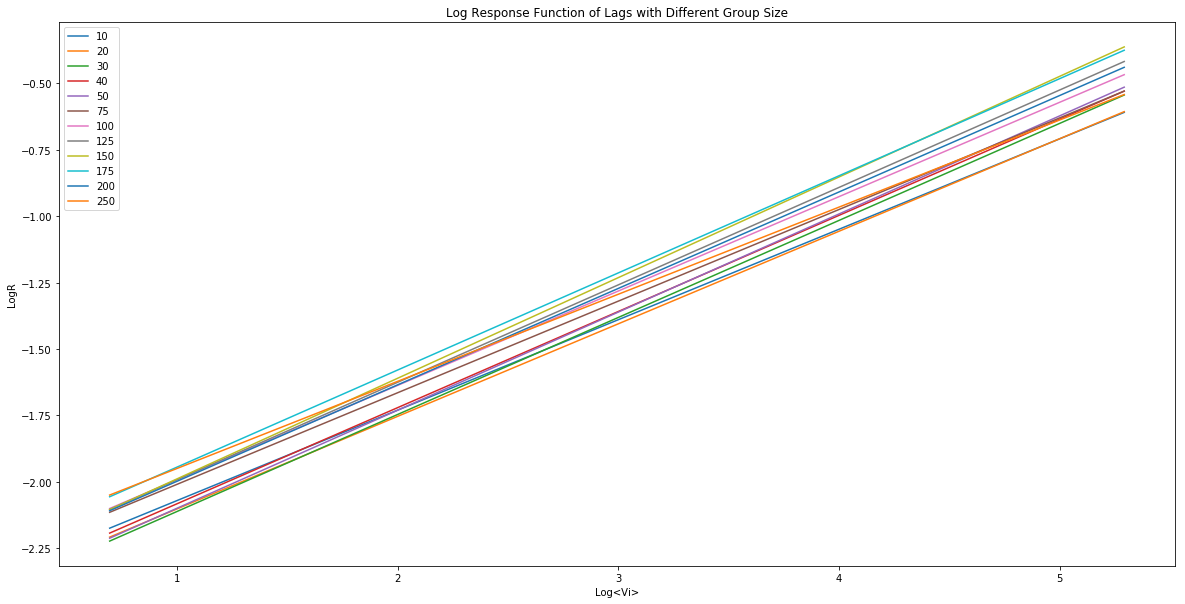

In [34]:
from math import log
import statsmodels.api as sm

LogR = pd.DataFrame()

logV = []
for group in [group0_2, group2_5, group5_10, group10_15, group15_20, 
          group20_30, group30_40, group40_55, group55_90, group90_100000]:
    logV.append(log(group['Size'].mean()))

logV_ols = sm.add_constant(logV)
slope = []
for i in [10,20,30,40,50,75,100,125,150,175,200,250]:
    Log_temp = LogRcalculate(i)
    model = sm.OLS(Log_temp, logV_ols).fit()
#     print(i,"slope:", model.params[1])
    slope.append(model.params[1])
    LogFit_temp = model.predict(logV_ols)
    LogFit_temp = pd.DataFrame(LogFit_temp)
    LogR = pd.concat([LogR, LogFit_temp], axis=1)

slope = pd.DataFrame(slope, columns = ['Slope'])
slope.index = [10,20,30,40,50,75,100,125,150,175,200,250]
slope.plot()
LogR = pd.concat([LogR,pd.DataFrame(logV, columns=['Log<Vi>'])], axis = 1)
LogR.set_index('Log<Vi>',inplace = True)
LogR.columns = [10,20,30,40,50,75,100,125,150,175,200,250]
q4 = LogR.plot(figsize=(20,10))
q4.set(title = 'Log Response Function of Lags with Different Group Size', ylabel = 'LogR')

Compare:
 (1) In the value perspective, the 150, 175 are two lags that have largest log response function, when the 250 is the middle level.
 (2) In the slope perspective, the 150 is also the highest too. The slope is not a linear function of lags, it increases at the first but when the lag beyond certain level, like 150, the slope begin decrease as the lag increase.
 (3) The slopes of different lags are in a relatively stable level. 
 